In [1]:
# Currently using maf_proto branch of rubin_sim

In [1]:
import healpy as hp
import pandas as pd
import numpy as np
import rubin_sim.maf_proto as maf
import sqlite3
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
# database file from:  https://s3df.slac.stanford.edu/data/rubin/sim-data/sv/sv_progress_databases/lsstcam_20250930/lsstcam_20250930.db
con = sqlite3.connect("lsstcam_20250930.db")
df = pd.read_sql("select * from observations;", con)
con.close()
# make sure we have a column named filter
df["filter"] = df["band"]
visits_array = df.to_records(index=False)

In [3]:
sl = maf.Slicer(nside=128)
metric = maf.CountMetric()
hp_array = sl(visits_array, metric)


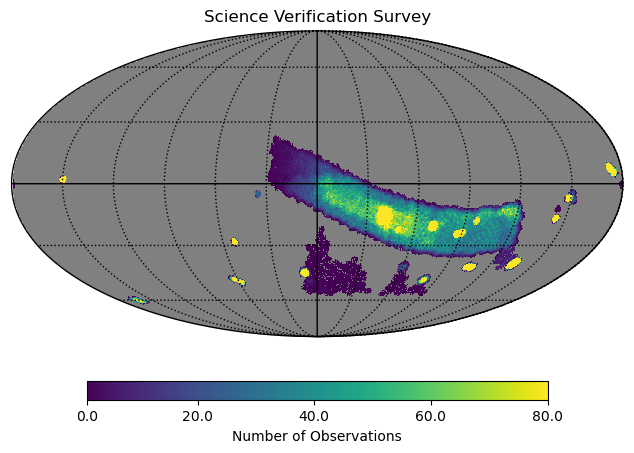

In [4]:
pm = maf.PlotMoll()
fig = pm(hp_array, max=80, title="Science Verification Survey", unit="Number of Observations")

In [5]:
fig.savefig("sv_num.pdf")

In [6]:
# hp.fitsfunc.write_map("lsstcam_20250930_nvisits.fits", hp_array)

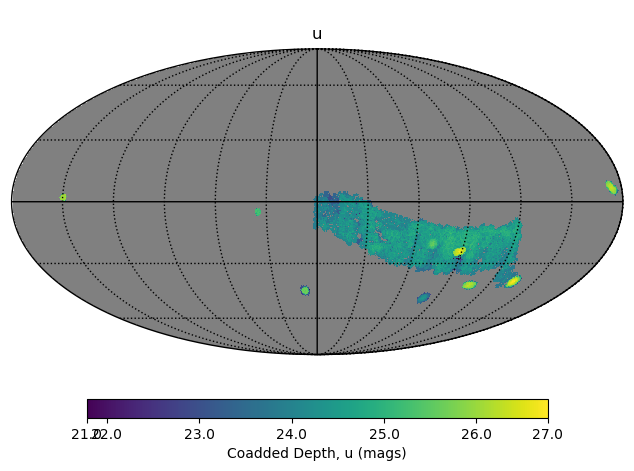

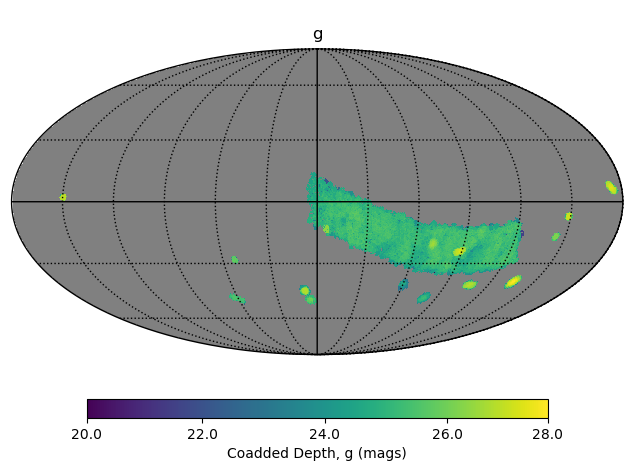

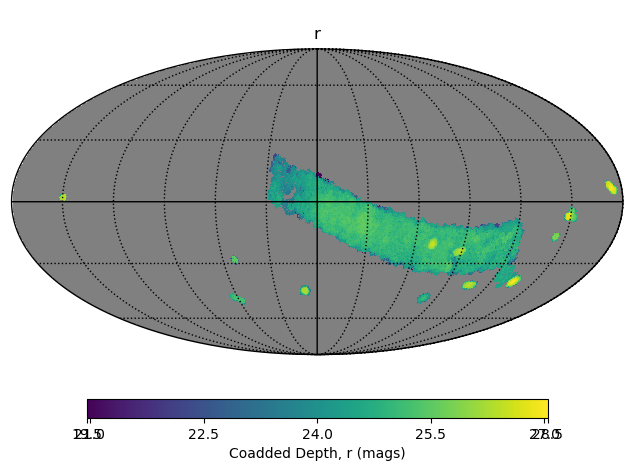

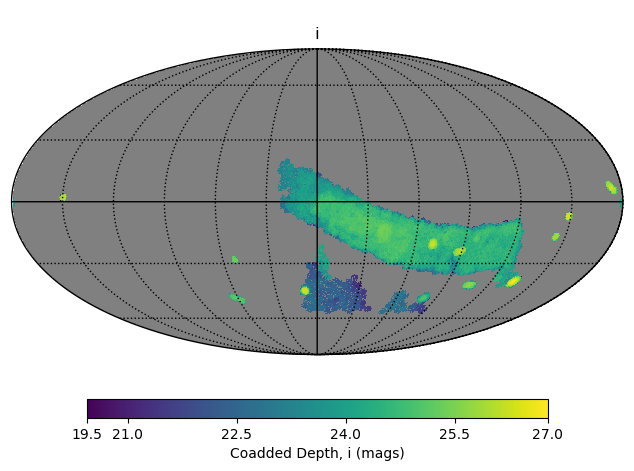

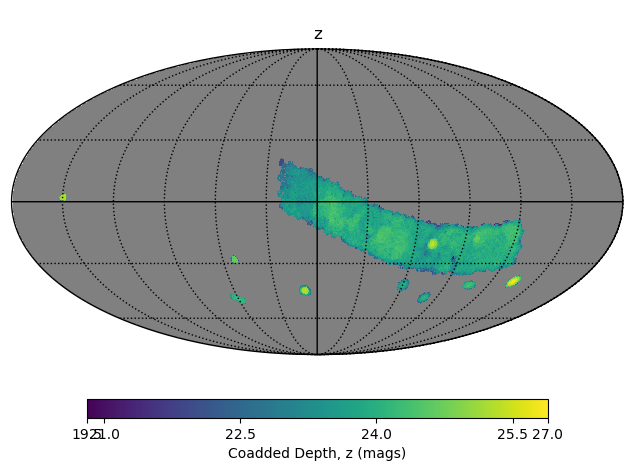

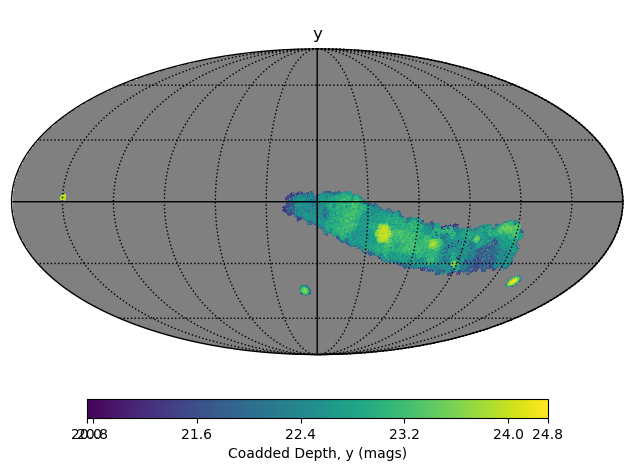

In [7]:
# Let's loop over each filter and compute the 5-sigma depth

# Note this is a naive algrbraic computation of coadded depth.
# Actuall realized depth will depend on coadd algorithm performance
# and which visits are actually selected to go into coadd.

sl = maf.Slicer(nside=128)
fig_saver = maf.FigSaver(close_figs=False)
dict_of_hparrays = {}
for bandname in "ugrizy":
    metric = maf.CoaddM5Metric(filtername=bandname)
    info={'observations_subset': bandname}
    # Select visits in correct filter and make sure seeing, etc were not NaN
    in_band = np.where((visits_array["band"] == bandname) & (np.isfinite(visits_array["fiveSigmaDepth"])))[0]
    hp_array, info = sl(visits_array[in_band], metric, info=info)
    dict_of_hparrays[bandname] = hp_array
    pm = maf.PlotMoll(info=info)
    fig = pm(hp_array)
    # To save the fig
    fig_saver(fig, info)

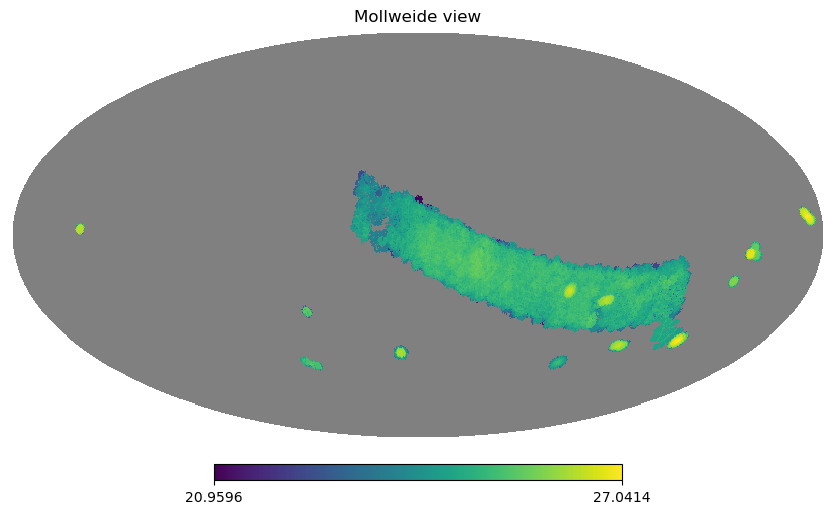

In [8]:
# and now if we want to inspect on of the arrays
hp.mollview(dict_of_hparrays["r"])